# NLP Asignment 4 , Rutik Pol 0120180213

# Video : https://www.youtube.com/watch?v=1KHzS83LIAU

In [8]:
!nvidia-smi

Wed Mar 17 23:42:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306... WDDM  | 00000000:2B:00.0  On |                  N/A |
|  0%   36C    P8    13W / 220W |    566MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os
import math
import datetime
import time

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

#RANDOM_SEED = 42

#np.random.seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

Using TensorFlow backend.


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
tf.__version__

'2.4.0'

# Data

The data contains various user queries categorized into seven intents. It is hosted on [GitHub](https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines) and is first presented in [this paper](https://arxiv.org/abs/1805.10190).

In [4]:
define_sent = [
    "What do you know about ",
    "What is ",
    "What information do you've on ",
    "I wonder if you know about ",
    "Hey, What's ",
    "Do you've any idea about ",
    "Hey, what is ",
    "Can you tell me about ",
    "I need to know more on ",
    "Describe ",
    "What's ",
    "Do you know ",
    "Did you know ",
    "Can't figure out ",
    "Help me with ",
    "Search ",
    "Find out about ",
    "Find me more on ",
    "Get me information on ",
    "Let me know about ",
    "What exactly is ",
    "I don't understand ",
    "I can't figure out ",
    "I wish I could know about ",
    "Can somebody tell me about ",
    "Damn! What is ",
    "Explain ",
    "Illustrate ", 
    "I want details on ",
    "Outline ",
    "Report on ",
    "Figure out ",
    "Google ",
    "Search ",
    ]

In [5]:
nouns = [
    "Coding",
    "AI",
    "Artificial Intelligence",
    "ML",
    "Data Science",
    "BERT",
    "Google",
    "Microsoft",
    "Windows",
    "Amazon",
    "Netflix",
    "Schumachder",
    "Senna",
    "Hamilton",
    "Rossi",
    "Australia",
    "Spain",
    "Jamaica",
    "Delhi",
    "Table",
    "Lamp",
    "Building",
    "Mountain",
    "Car",
    "Dog",
    "Cat",
    "Ferrari",
    "Maserati",
    "Sun",
    "Moon",
    "Milky Way",
    "Rimac",
    "Arduino",
    "Intel",
    "Webinar",
    "Spain",
    "waves",
    "human",
    "monkey",
    "giraffe",
    "turkey",
    "station",
    "phones",
    "Android",
    "fan",
    "clock",
    "popcorn",
    "dosa",
    "chips",
    "rice",
    "AIDS",
    "NLP",
    "money",
    "cash",
    "dollars",
    "London",
    "Trinidad",
    "Perth",
    "transformers"
]

In [6]:
salutation = [
    "Hey",
    "Hi",
    "Sup",
    "Wassup",
    "Hello",
    "Hello There",
    "How's it going",
    "How are you doing",
    "How are you",
    "What's Up",
    "Whats New",
    "Whats going on",
    "Hows life",
    "Hows Things",
    "How was your day",
    "Good to see you",
    "Nice to see you",
    "Long time no see",
    "Its been a while",
    "Good Morning",
    "Good Afternoon",
    "Good Evening",
    "Its nice to meet you",
    "Pleased to meet you",
    "How have you been",
    "How do you do",
    "YO",
    "Alright Mate",
    "Hiya"
]

In [7]:
text = []

for i in define_sent:
    for j in nouns:
        text.append(i + j)
        
df = pd.DataFrame(text, columns = ['text'])
df['intent'] = "Define"
df.sample(n = 10)

,text,intent
261,"Hey, What's Cat",Define
1870,Figure out station,Define
1283,I don't understand fan,Define
257,"Hey, What's Building",Define
1567,Explain Intel,Define
1137,Let me know about Spain,Define
130,What information do you've on Senna,Define
1622,Illustrate Moon,Define
836,Help me with Netflix,Define
1746,Outline Spain,Define


In [8]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [9]:
train = train.append(valid).reset_index(drop=True)

In [10]:
train.shape

(13784, 2)

In [11]:
"""train = train[(train['intent'] == 'PlayMusic') | (train['intent'] == 'GetWeather')]
test = test[(test['intent'] == 'PlayMusic') | (test['intent'] == 'GetWeather')]"""

train = train[train['intent'] != "AddToPlaylist"]
test = test[test['intent'] != "AddToPlaylist"]

In [12]:
train = train.append(df).reset_index(drop=True)
test = test.append(df.sample(n=100)).reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


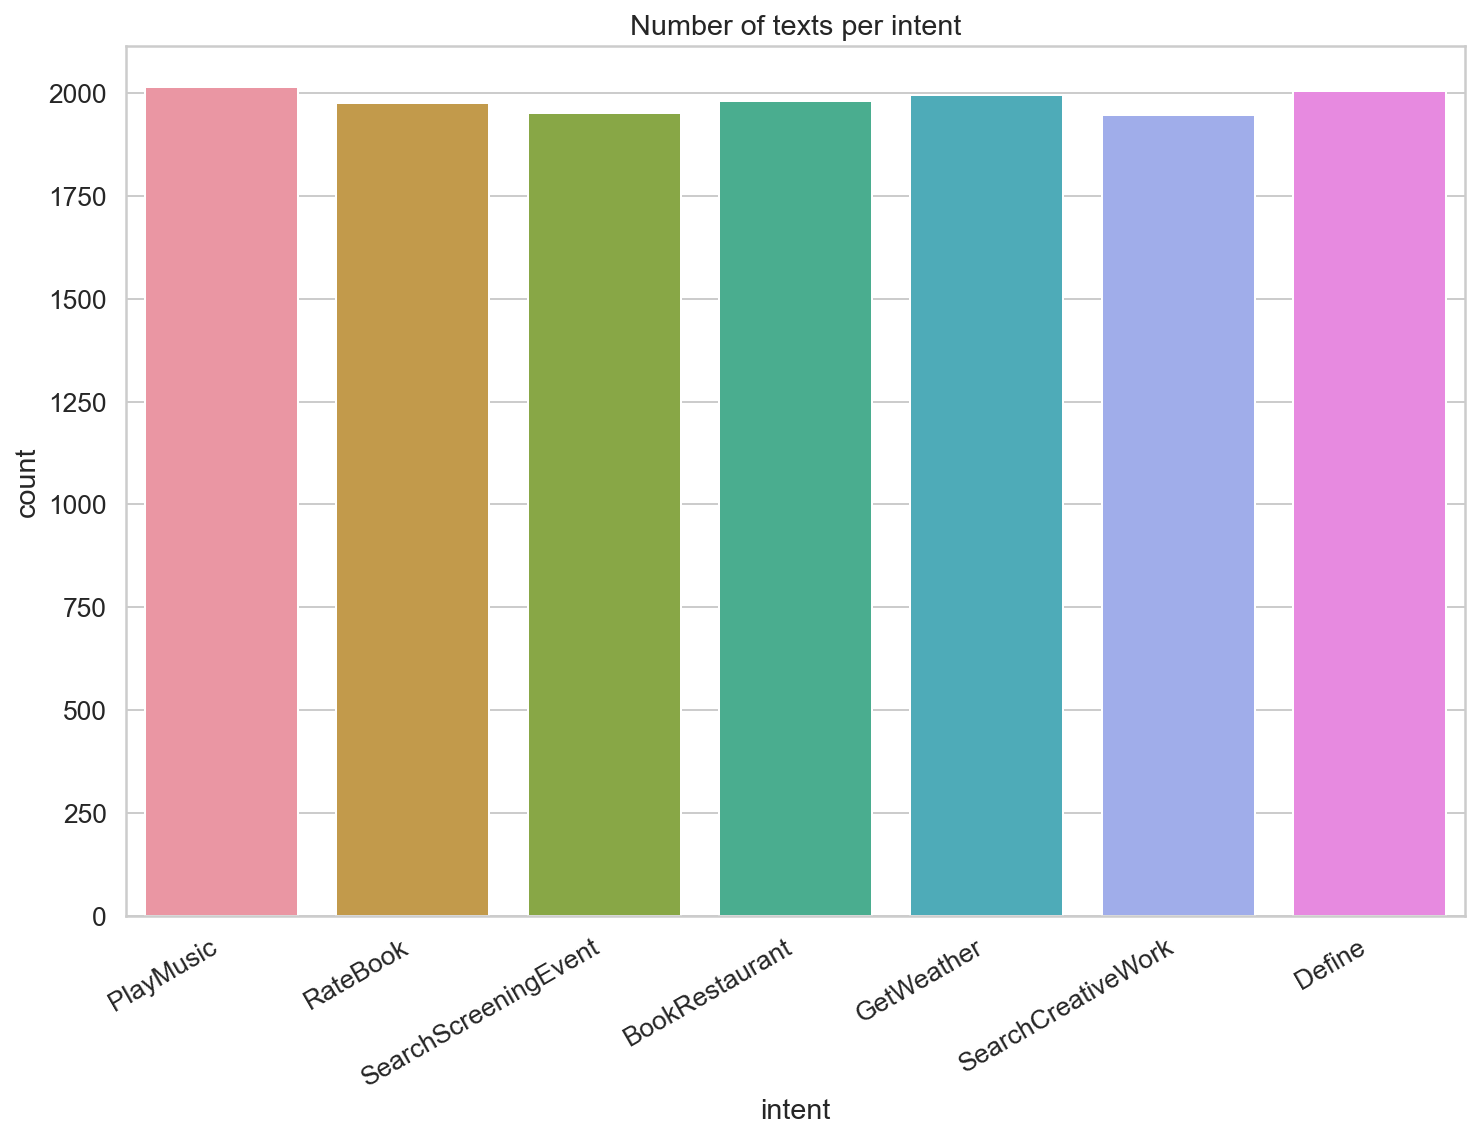

In [13]:
chart = sns.countplot(train.intent)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Intent Recognition with BERT

In [14]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [15]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x .append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [16]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [17]:
tokenizer.tokenize("What do you know about Michael Schumacher?")



['what', 'do', 'you', 'know', 'about', 'michael', 'schumacher', '?']

In [18]:
tokens = tokenizer.tokenize("What do you know about Michael Schumacher?")
tokenizer.convert_tokens_to_ids(tokens)

[2054, 2079, 2017, 2113, 2055, 2745, 22253, 1029]

In [19]:
def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model

## Training

In [20]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13872it [00:01, 7623.42it/s]
<ipython-input-15-04d83c621cd8>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(x), np.array(y)
676it [00:00, 7763.00it/s]

max seq_len 38


In [21]:
classes

['PlayMusic',
 'RateBook',
 'SearchScreeningEvent',
 'BookRestaurant',
 'GetWeather',
 'SearchCreativeWork',
 'Define']

In [52]:
data.train_x.shape

(13872, 38)

In [53]:
data.train_x[0]

array([ 101, 2377, 3769,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [54]:
data.train_y[0]

0

In [55]:
data.max_seq_len

38

In [56]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x000001F9178C4F40> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 5383

In [58]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [59]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=64,
  shuffle=True,
  epochs=2,
)

Epoch 1/2
196/196 [==============================] - 76s 334ms/step - loss: 1.3724 - acc: 0.4829 - val_loss: 0.0332 - val_acc: 0.9928
Epoch 2/2
196/196 [==============================] - 64s 325ms/step - loss: 0.0884 - acc: 0.9748 - val_loss: 0.0273 - val_acc: 0.9950


In [64]:
model_json = model.to_json()
with open("bert_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [63]:
model.save_weights('bert_weights.h5')
model.load_weights('bert_weights.h5')

## Evaluation

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

#print("train acc", train_acc)
print("test acc", test_acc)

In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# API Integration 
# Named Entity Recognition
# POS tagging

In [ ]:
import spacy
import requests
import webbrowser
from time import sleep
from youtube_search import YoutubeSearch
from random import shuffle
import wikipedia

import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
from googlesearch import search

In [ ]:
def sentences_to_token_id(sentences):
    pred_tokens = map(tokenizer.tokenize, sentences)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))
    
    return pred_token_ids
    

In [ ]:
def albert(sentences):
    
    """weather_queries = ["I wonder if its raining in Mumbai!",
                  "What's the Weather like London?",
                   "Get me Delhi weather now!",
                  "Is it hot in Alandi right now?"]

    music_queries = ["Play Beliver",
                     "I want to hear Rap_God",
                     "Let's listen to Faded",
                     "I'd like to hear Demons"]

    define_queries = ["Tell me about Vettel",
                      "What is AMD",
                      "I want to know about BERT_model",
                      "What the fcuk is Artificial_Intelligence"]

    sentences = weather_queries + music_queries + define_queries
    #shuffle(sentences)"""

    sentences_id = sentences_to_token_id(sentences)

    predictions = model.predict(sentences_id).argmax(axis=-1)

    for text, label in zip(sentences, predictions):
        wikitxt = nlp(text)

        #print("Query : ", text, "\nPrdeicted Intent : ", classes[label])
        if classes[label] == 'GetWeather':
            wikitxt = wikitxt.ents
            wikitxt = [i for i in wikitxt if i.label_ == 'GPE']
            api_address='http://api.openweathermap.org/data/2.5/weather?appid=640dcd9a166b017ee19a37d108c20553&q='
            city = str(wikitxt[0])
            url = api_address + city
            json_data = requests.get(url).json()
            print("\nCurrently we've {} in {}.".format(json_data['weather'][0]['description'], city))
            print("Wind is flowing @ {}kmph.".format(json_data['wind']['speed']))
            print("Temperature : {} Celcius with {}% humidity.".format(str(json_data['main']['temp']-273)[:4], json_data['main']['humidity']))
            print()

        elif classes[label] == 'PlayMusic':
            """song = [str(word) for word in wikitxt if word.tag_[:2] == 'NN']
            print("\nSure thing, Playing ", song[0], " on Youtube.")
            result = YoutubeSearch(song[0] + " song", max_results=1).to_dict()
            webbrowser.open('www.youtube.com' + result[0]['url_suffix'])"""
            print("Predicted Intent: Play Music")
            song = [str(word) for word in wikitxt if word.tag_[:2] == 'NN']
            result = YoutubeSearch(song[0] + " song", max_results=1).to_dict()
            print("Go to: " + str('www.youtube.com' + result[0]['url_suffix']))
            webbrowser.open('www.youtube.com' + result[0]['url_suffix'])

        elif classes[label] == 'RateBook':
            print("Predicted Intent: Rate Book")
            print("I just found a brilliant community page to rate books!")
            webbrowser.open("Visit: https://www.goodreads.com/")

        elif classes[label] == "SearchScreeningEvent":
            print("Predicted Intent: Search Screening Event")
            print("I'm sorry to remind most theaters are close, but try your luck")
            webbrowser.open("https://in.bookmyshow.com/")

        elif classes[label] == 'BookRestaurant':
            print("Predicted Intent: Book Restaurant")
            print("\nSure thing, Enjoy yor Supper !!")
            webbrowser.open("https://www.zomato.com")

        elif classes[label] == 'SearchCreativeWork':
            print("Predicted Intent: Search Creative Work")
            print("\nWell, Beauty lies in the eyes of the beholder..")
            print("\nThe Drum has some Brilliant Creative Works, I'd suggest you should have a look.")
            webbrowser.open("https://www.thedrum.com/creative-works")

        elif classes[label] == 'AddToPlaylist':
            print("Predicted Intent: Add To Playlist")
            print("Sorry, Google dropped support for Play Music API, we'll patch this later")

        elif classes[label] == 'Define':
            query = [str(word) for word in wikitxt if word.tag_ == 'NNP']
            try:
                summary = wikipedia.summary(query[-1], sentences = 3)
                print("\nSummary : " + summary + "\n")
            except:
                print("\nI guess there isn't a wiki page for that term...\n")
                query = [str(word) for word in wikitxt if word.tag_[:2] == 'NN']
                x = [i for i in search(str(query[-1]), tld="com", num = 3, stop=3, pause=0)]
                for j in x:
                    print(j)

                """query = [str(word) for word in wikitxt if word.tag_[:2] == 'NN']
                try:
                    summary = wikipedia.summary(query[-1], sentences = 3)
                except wikipedia.DisambiguationError as e:
                    summary = wikipedia.summary(e.options[0], sentences = 3)
            except wikipedia.DisambiguationError as e:
                summary = wikipedia.summary(e.options[0], sentences = 3)"""

In [ ]:
albert(["Let's listen to Delicate"])

In [ ]:
albert(["Play Beliver"])

In [ ]:
albert(["What's the Weather like London?"])

In [ ]:
albert(["Is it hot in Berkeley right now?"])

In [ ]:
albert(["Get me Mumbai's weather now!"])

In [ ]:
albert(["What is Intel"])

In [ ]:
albert(["Tell me about BERT_Model"])

In [ ]:
albert(["What is Ferrari"])

In [ ]:
albert(["Need information on IPL"])

In [ ]:
albert(["Help me with a fine dine restaurant"])

In [ ]:
albert(["Wonder how Mona Lisa looks like"])

# Deployment

In [66]:
JSON_LOCATION = 'bert_architecture.json'
WEIGHTS_LOCATION = 'bert_weights.h5'


from keras.models import model_from_json
json_file = open(JSON_LOCATION, 'r')
loaded_model_json = json_file.read()
json_file.close()
    
model = model_from_json(loaded_model_json, custom_objects={"BertModelLayer": bert.BertModelLayer})
   # load weights into new model
model.load_weights(WEIGHTS_LOCATION)
print("loaded model from JSON_LOCATION and WEIGHTS_LOCATION")

loaded model from JSON_LOCATION and WEIGHTS_LOCATION


In [79]:
def convert_h5_to_aws(loaded_model):
    """
    given a pre-trained keras model, this function converts it to a TF protobuf format
    and saves it in the file structure which aws expects
    """  
    from tensorflow.python.saved_model import builder
    from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
    from tensorflow.python.saved_model import tag_constants
    
    # This is the file structure which AWS expects. Cannot be changed. 
    model_version = '1'
    export_dir = 'export/Servo/' + model_version
    
    # Build the Protocol Buffer SavedModel at 'export_dir'
    builder = builder.SavedModelBuilder(export_dir)
    
    # Create prediction signature to be used by TensorFlow Serving Predict API
    signature = predict_signature_def(
        inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})
    
    import tensorflow.python.keras.backend as K
    with K.get_session() as sess:
        # Save the meta graph and variables
        builder.add_meta_graph_and_variables(
            sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
        builder.save()
    
    #create a tarball/tar file and zip it
    import tarfile
    with tarfile.open('model.tar.gz', mode='w:gz') as archive:
        archive.add('export', recursive=True)
        
convert_h5_to_aws(model)

AssertionError: Export directory already exists, and isn't empty. Please choose a different export directory, or delete all the contents of the specified directory: export/Servo/1